# MCMC Demo

## Run MCMC

In [1]:
import yaml
from espei import run_espei
from pycalphad import Database

In [6]:
with open('ESPEI_demo.yaml') as fp:
    mcmc_settings = yaml.safe_load(fp)
dbf_mcmc, sampler = run_espei(mcmc_settings)

INFO:espei.espei_script - espei version       0.0.0
INFO:espei.espei_script - If you use ESPEI for work presented in a publication, we ask that you cite the following paper:
    B. Bocklund, R. Otis, A. Egorov, A. Obaied, I. Roslyakova, Z.-K. Liu, ESPEI for efficient thermodynamic database development, modification, and uncertainty quantification: application to Cu-Mg, MRS Commun. (2019) 1-10. doi:10.1557/mrc.2019.59.
INFO:espei.espei_script - Not using a parallel scheduler. ESPEI is running MCMC on a single core.
INFO:espei.error_functions.context - Fitting 2 degrees of freedom.
INFO:espei.optimizers.opt_mcmc - Initializing a zero prior for the parameters.
INFO:espei.optimizers.opt_mcmc - Initializing 16 chains with 8 chains per parameter.
INFO:espei.optimizers.opt_mcmc - Using a deterministic ensemble sampler.
INFO:espei.optimizers.opt_mcmc - Running MCMC for 10 iterations.
[                              ] (1 of 10)

[###                           ] (2 of 10)

[######                

## Uncertainty quantification and propagation

### Convergence plot

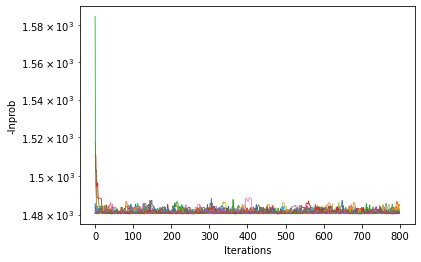

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from espei.analysis import truncate_arrays
trace = np.load('trace.npy')
lnprob = np.load('lnprob.npy')
trace, lnprob = truncate_arrays(trace, lnprob)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('-lnprob')
num_chains = lnprob.shape[0]
for i in range(num_chains):
    ax.plot(-lnprob[i,:], linewidth=0.8)
plt.show()

### Visualize parameter value changes during MCMC

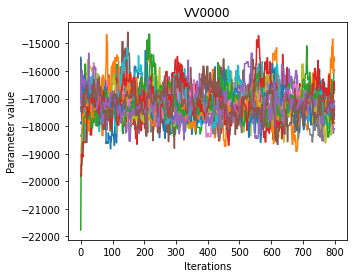

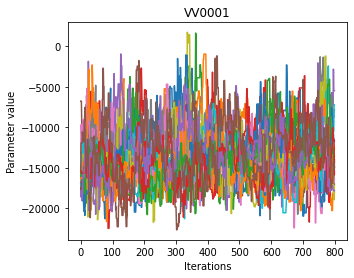

In [20]:
trace = np.load('trace.npy')
lnprob = np.load('lnprob.npy')
trace, lnprob = truncate_arrays(trace, lnprob)

num_chains = trace.shape[0]
num_parameters = trace.shape[2]
for parameter in range(num_parameters):
    title='VV000'+str(parameter)
    plt.figure(figsize=[5,4])
    plt.xlabel('Iterations')
    plt.ylabel('Parameter value')
    plt.plot(trace[..., parameter].T)
    plt.title(title)
    plt.show()

### Visualize parameter relationship

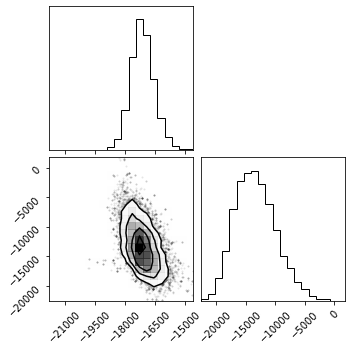

In [21]:
import corner
trace = np.load('trace.npy')
lnprob = np.load('lnprob.npy')

trace, lnprob = truncate_arrays(trace, lnprob)

# flatten the along the first dimension containing all the chains in parallel
fig = corner.corner(trace.reshape(-1, trace.shape[-1]))
plt.show()

### Propagate uncertainty of parameters to property

/var/folders/4y/wsjvxx815z77v574ftqz7_780000gn/T/ipykernel_73282/2433150883.py:27: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  cutoff_probability = np.quantile(flat_lnprob, 1-credible_interval, interpolation='lower')


<Figure size 432x288 with 0 Axes>

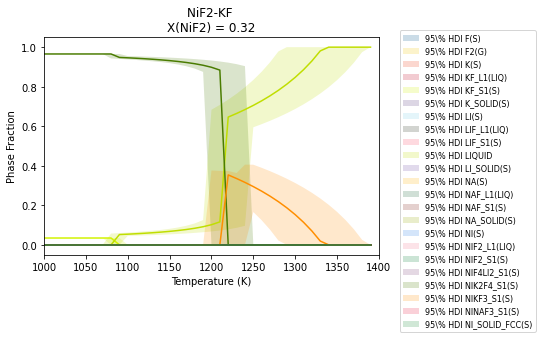

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import corner
from pycalphad import Database, binplot, equilibrium, variables as v
from pycalphad.plot.utils import phase_legend
from espei.datasets import load_datasets, recursive_glob
from espei.analysis import truncate_arrays
from espei.plot import plot_interaction, dataplot
from espei.utils import formatted_parameter, database_symbols_to_fit, optimal_parameters
from pycalphad.models.model_mqmqa import ModelMQMQA
from pycalphad.plot.eqplot import eqplot

#equilibrium calculations at x(NiF2)=0.32
dbf = Database('MCMC_demo.xml')
comps = ['NI', 'K', 'F']
phases = list(dbf.phases.keys())
conds = {v.N: 1, v.P: 101325, v.T: (1000,1400,10), v.X('NI'):0.137931034482759, v.X('K'):0.293103448275862}
eq_1 = equilibrium(dbf, comps, phases, conds, verbose=False)

#load trace
trace = np.load('trace.npy')
lnprob = np.load('lnprob.npy')

#screen parameter within certain credible interval after burn-in iterations
def _highest_density_indices(flat_lnprob, credible_interval=0.95):
    cutoff_probability = np.quantile(flat_lnprob, 1-credible_interval, interpolation='lower')
    return np.nonzero(flat_lnprob > cutoff_probability)[0]
def highest_density_parameters(trace, lnprob, credible_interval=0.95, burn_in=1):
    flat_lnprob = lnprob[:,burn_in:].reshape(-1)
    hdi_idx = _highest_density_indices(flat_lnprob, credible_interval)
    flat_trace = trace[:, burn_in:, :].reshape(-1, trace.shape[-1])
    return flat_trace
symbols_to_fit = database_symbols_to_fit(dbf)
flat_params = highest_density_parameters(trace, lnprob, burn_in=795)

#running equilibirum calculations for sets of parameters after screening
eq_results = []
for param_idx in range(flat_params.shape[0]):
    parameters = dict(zip(symbols_to_fit, flat_params[param_idx, :]))
    eq_res = equilibrium(dbf, comps, phases, conds, parameters=parameters)
    eq_results.append(eq_res) 
eq_up_result = xr.concat(eq_results, 'samples')
params = dict(zip(database_symbols_to_fit(dbf), optimal_parameters(trace, lnprob)))
dbf.symbols.update(params)
eq_opt_result = equilibrium(dbf, comps, phases, conds, parameters=params)
_hndls, colors = phase_legend(phases)

#
prop = 'NP'
plt.clf()
fig = plt.figure()
ax = fig.add_subplot()

for phase_name in phases:
    msk = eq_up_result.Phase == phase_name
    eq_prop = eq_up_result[prop].where(msk).sum(dim='vertex').squeeze() 
    ax.fill_between(eq_up_result.T, eq_prop.min(dim='samples'), eq_prop.max(dim='samples'), alpha=0.2, color=colors[phase_name], edgecolor=None, label='95\% HDI'+' '+f'{phase_name}')
    ax.plot(eq_opt_result.T, eq_opt_result[prop].where(eq_opt_result.Phase == phase_name).sum(dim='vertex').squeeze(), color=colors[phase_name])
ax.set_title(f'NiF2-KF \nX(NiF2) = {0.32:0.2f}')
ax.set_ylabel('Phase Fraction')
ax.set_xlabel('Temperature (K)')
ax.legend(fontsize='small',bbox_to_anchor=(1.05, 1.05), prop={'size': 8})
ax.set_xlim(1000, 1400)
plt.show()
